1) Evaluate the performance and trends of each category by exploring the dataset. Do you find any specific pattern or anomaly? Are there any notable changes or improvements over the 4-year period?

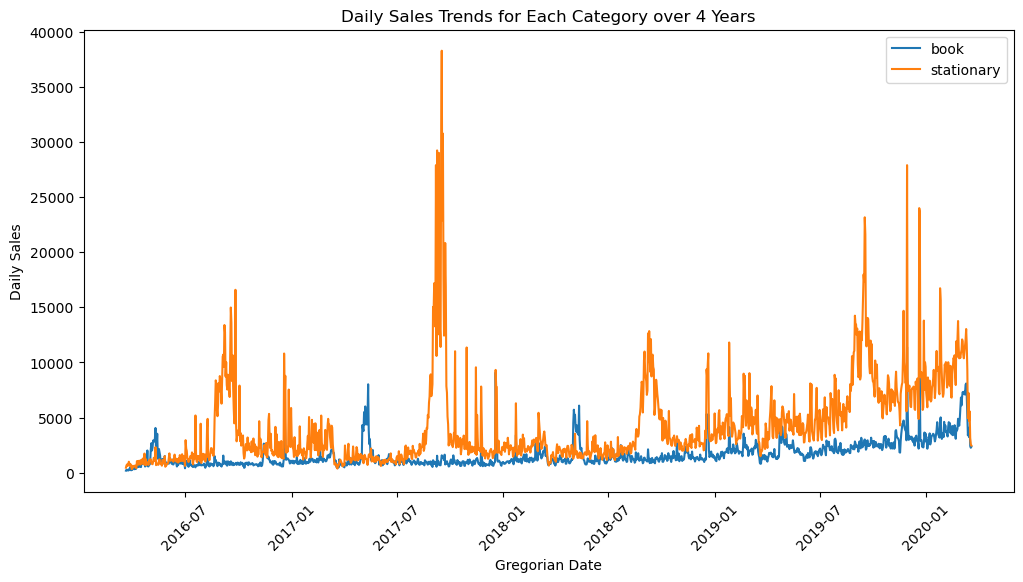

In [1]:
# Import required libraries 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from persiantools.jdatetime import JalaliDate
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import calendar 


# Load the dataset
file_path = r'C:\Users\Asus\OneDrive\Desktop\Digikala task\Planning_Task.csv'
df = pd.read_csv(file_path)

# Rename the column
df.rename(columns={' Net Item Fcast ': 'Net Item Sales'}, inplace=True)

# Define a mapping between month names and month numbers
month_mapping = {
    'Farvardin': '01',
    'Ordibehesht': '02',
    'Khordad': '03',
    'Tir': '04',
    'Mordad': '05',
    'Shahrivar': '06',
    'Mehr': '07',
    'Aaban': '08',
    'Aazar': '09',
    'Dey': '10',
    'Bahman': '11',
    'Esfand': '12'
}

# Map month names to month numbers
df['Persian Month Number'] = df['Persian Month Name En'].map(month_mapping)

# Remove thousands separators (commas) from the 'Net Item Sales' column
df['Net Item Sales'] = df['Net Item Sales'].str.replace(',', '')

# Calculate daily sales for each category
df['Net Item Sales'] = pd.to_numeric(df['Net Item Sales'], errors='coerce')  # Convert to numeric

# Create a pseudo-date column
def convert_to_gregorian(row):
    jalali_date = JalaliDate(int(row['Persian Year']), int(row['Persian Month Number']), int(row['Persian Day Number Of Month']))
    return jalali_date.to_gregorian()

df['Gregorian Date'] = df.apply(convert_to_gregorian, axis=1)

df['Gregorian Date'] = pd.to_datetime(df['Gregorian Date'])  # Convert to datetime
# Extract month number and create a new column
df['Gregorian Month Number'] = df['Gregorian Date'].dt.month
# Extract month number and create a new column
df['Gregorian Year'] = df['Gregorian Date'].dt.year

# Calculate average daily sales and total sales for each category
category_sales = df.groupby('Category')['Net Item Sales'].sum()
category_days = df.groupby('Category')['Gregorian Date'].nunique()
category_avg_daily_sales = category_sales / category_days
total_sales_4_years = category_sales.sum()

# Visualize trends: Line charts for daily sales over 4 years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Gregorian Date', y='Net Item Sales', hue='Category')
plt.xlabel('Gregorian Date')
plt.ylabel('Daily Sales')
plt.title('Daily Sales Trends for Each Category over 4 Years')
plt.legend()
plt.xticks(rotation=45,size=10)
plt.show()

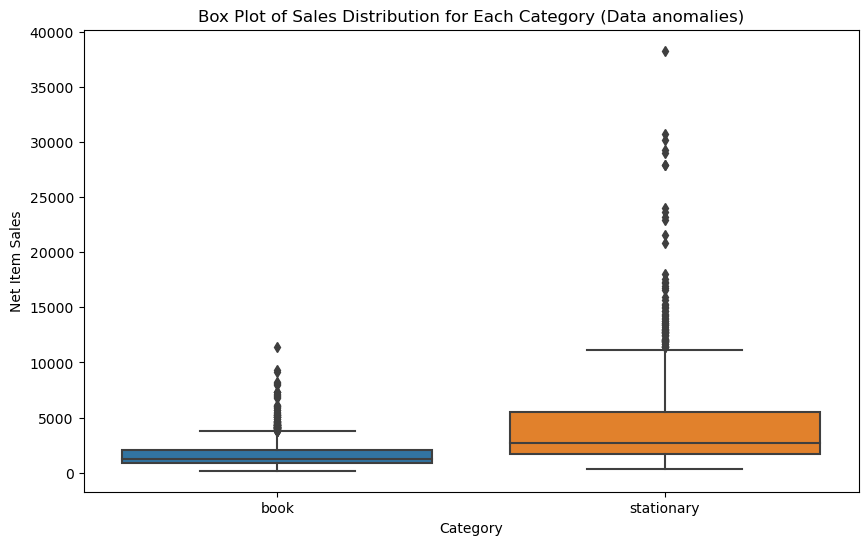

In [2]:
# Set 'Gregorian Date' column as the index
df.set_index('Gregorian Date', inplace=True)  # Set as index

# Identify anomalies using z-score
def detect_anomalies(series):
    z_scores = np.abs((series - series.mean()) / series.std())
    threshold = 3  
    anomalies = series[z_scores > threshold]
    return anomalies

anomalies_book = detect_anomalies(df[df['Category'] == 'book']['Net Item Sales'])
anomalies_stationary = detect_anomalies(df[df['Category'] == 'stationary']['Net Item Sales'])

# Visualize anomalies using box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Category', y='Net Item Sales')
plt.title('Box Plot of Sales Distribution for Each Category (Data anomalies)')
plt.show()


In [3]:
# Summarize findings
summary_df1 = pd.DataFrame({'Average Daily Sales': category_avg_daily_sales})
print("Total Sales over 4 Years: {:.2f}".format(total_sales_4_years))
summary_df2 = pd.DataFrame({'Anomalies in "book" category': anomalies_book})
summary_df3 = pd.DataFrame({'Anomalies in "stationary" category': anomalies_stationary})
display(summary_df1)
display(summary_df2)
display(summary_df3)

Total Sales over 4 Years: 8490104.00


,Average Daily Sales
Category,
book,1646.373288
stationary,4168.766438


,"Anomalies in ""book"" category"
Gregorian Date,
2016-12-20,5447
2017-05-06,5491
2017-05-08,6006
2017-05-12,5270
2017-05-13,8014
2017-12-19,9092
2017-12-20,5645
2018-05-03,5708
2018-05-05,5250


,"Anomalies in ""stationary"" category"
Gregorian Date,
2016-09-26,16587
2017-09-04,17182
2017-09-07,27894
2017-09-09,29229
2017-09-12,29007
2017-09-16,30205
2017-09-17,38273
2017-09-18,22896
2017-09-19,30758


In [4]:
# Group data by category, year, and quarter, and sum the quarterly sales
grouped_data = df.groupby(['Category', 'Persian Year', 'Persian Month Name En', 'Persian Day Number Of Month'])['Net Item Sales'].sum().reset_index()

# Separate data for each category
book_data = grouped_data[grouped_data['Category'] == 'book']
stationary_data = grouped_data[grouped_data['Category'] == 'stationary']

# Define a function to detect outliers using Z-score
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return z_scores > threshold

# Define a function to detect outliers using IQR
def detect_outliers_iqr(data, multiplier=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return (data < lower_bound) | (data > upper_bound)

# Detect outliers for 'book' category using Z-score
outliers_zscore_book = detect_outliers_zscore(book_data['Net Item Sales'])
outliers_zscore_stationary = detect_outliers_zscore(stationary_data['Net Item Sales'])

# Detect outliers for 'stationary' category using IQR
outliers_iqr_book = detect_outliers_iqr(book_data['Net Item Sales'])
outliers_iqr_stationary = detect_outliers_iqr(stationary_data['Net Item Sales'])

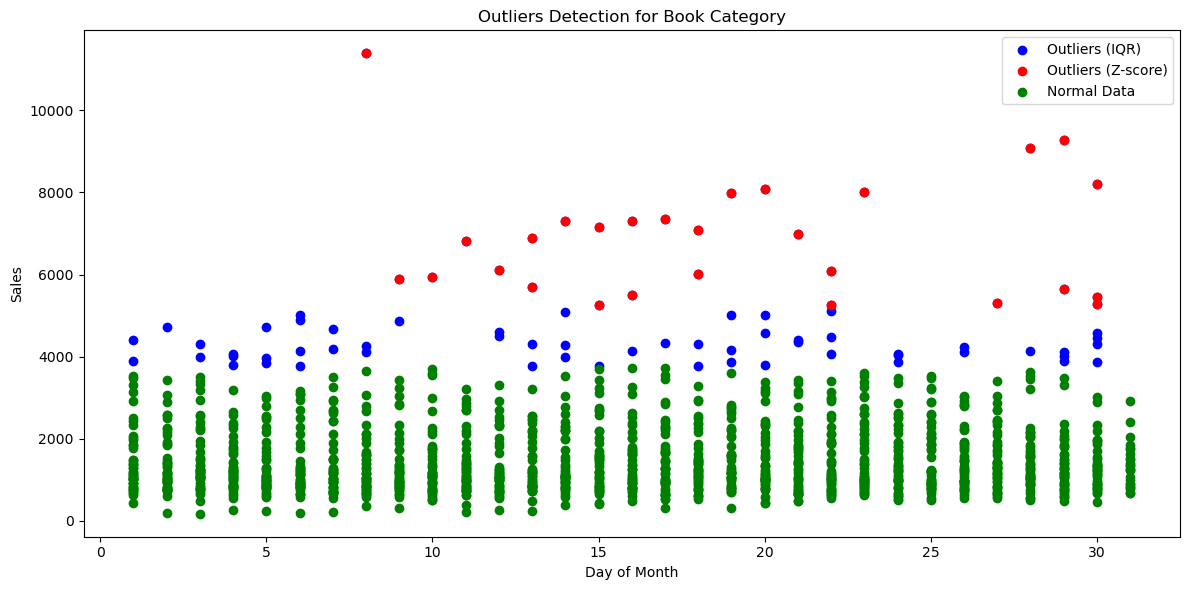

In [5]:
# Plot outliers for 'book' category
plt.figure(figsize=(12, 6))
plt.scatter(book_data[outliers_iqr_book]['Persian Day Number Of Month'], book_data[outliers_iqr_book]['Net Item Sales'], color='blue', label='Outliers (IQR)')
plt.scatter(book_data[outliers_zscore_book]['Persian Day Number Of Month'], book_data[outliers_zscore_book]['Net Item Sales'], color='red', label='Outliers (Z-score)')
plt.scatter(book_data[~outliers_zscore_book & ~outliers_iqr_book]['Persian Day Number Of Month'], book_data[~outliers_zscore_book & ~outliers_iqr_book]['Net Item Sales'], color='green', label='Normal Data')
plt.xlabel('Day of Month')
plt.ylabel('Sales')
plt.title('Outliers Detection for Book Category')
plt.legend()
plt.tight_layout()
plt.show()

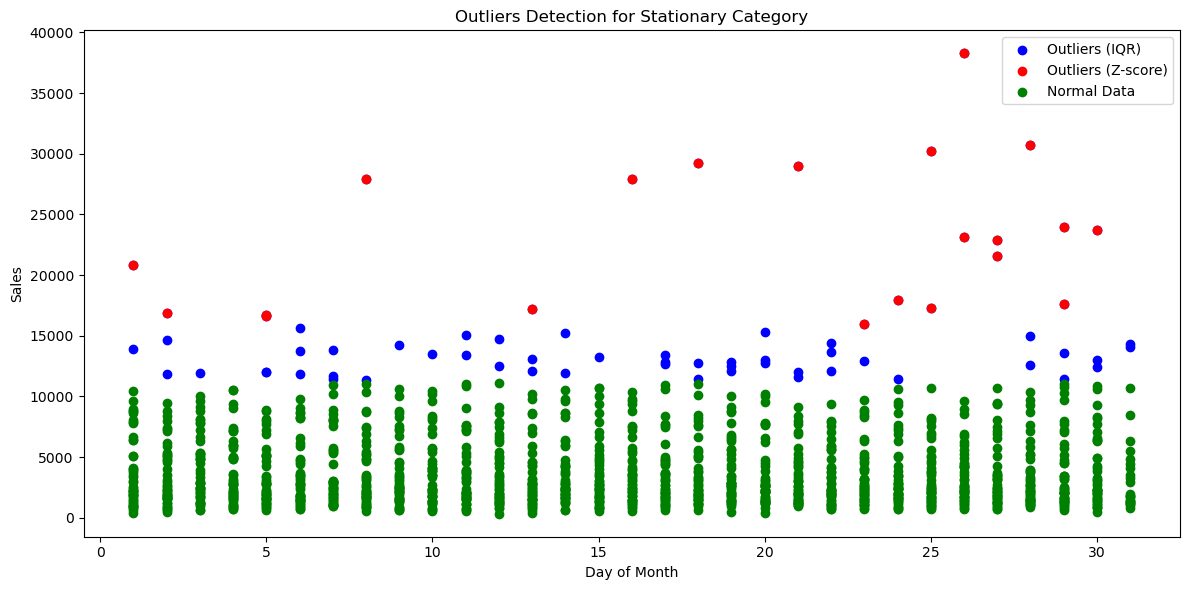

In [6]:
# Plot outliers for 'stationary' category
plt.figure(figsize=(12, 6))
plt.scatter(stationary_data[outliers_iqr_stationary]['Persian Day Number Of Month'], stationary_data[outliers_iqr_stationary]['Net Item Sales'], color='blue', label='Outliers (IQR)')
plt.scatter(stationary_data[outliers_zscore_stationary]['Persian Day Number Of Month'], stationary_data[outliers_zscore_stationary]['Net Item Sales'], color='red', label='Outliers (Z-score)')
plt.scatter(stationary_data[~outliers_zscore_stationary & ~outliers_iqr_stationary]['Persian Day Number Of Month'], stationary_data[~outliers_zscore_stationary & ~outliers_iqr_stationary]['Net Item Sales'], color='green', label='Normal Data')
plt.xlabel('Day of Month')
plt.ylabel('Sales')
plt.title('Outliers Detection for Stationary Category')
plt.legend()
plt.tight_layout()
plt.show()

2) Apply statistical techniques or models to identify and analyze seasonality patterns in the data. Explain if there are any significant seasonal effects for each category.

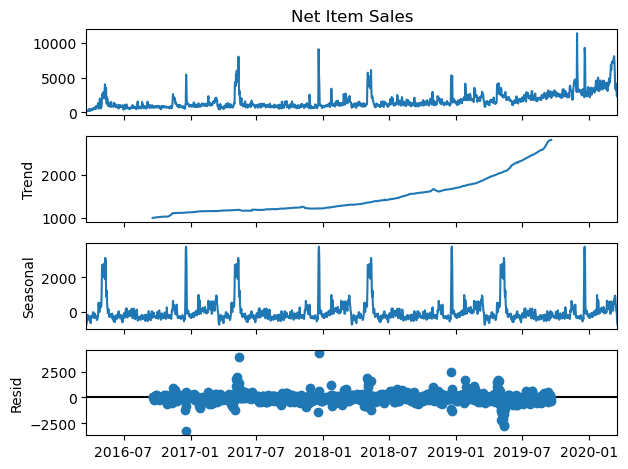

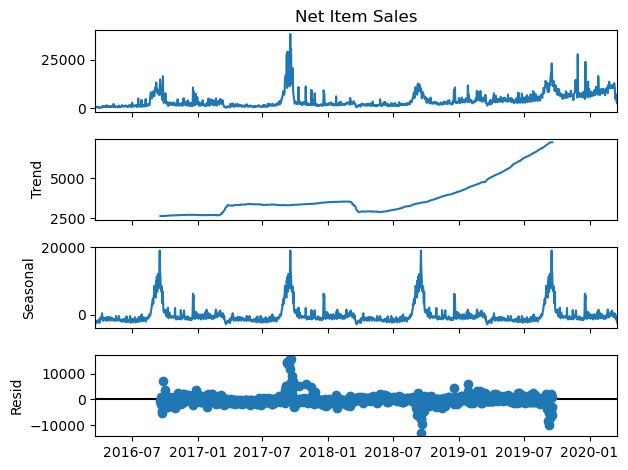

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series for each category
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]['Net Item Sales']
    result = seasonal_decompose(category_data, model='additive', period=365)  # Adjust period as needed
    result.plot()

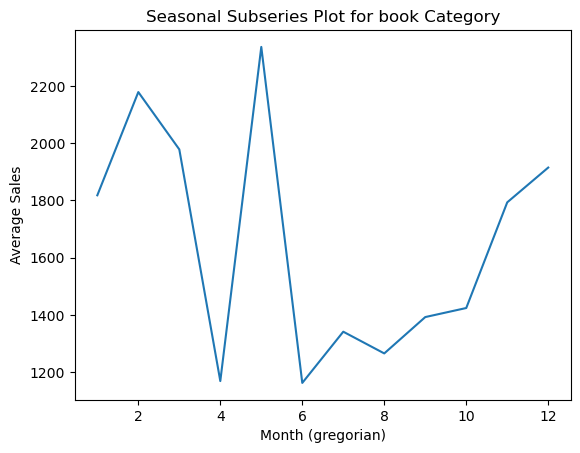

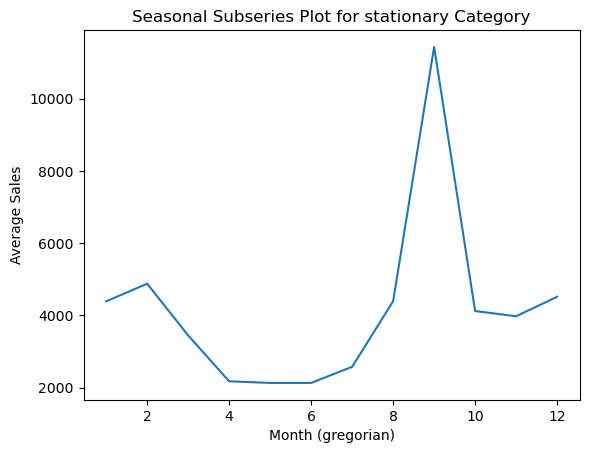

In [8]:
# Plot seasonal subseries for each category
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]['Net Item Sales']
    seasonal_subseries = category_data.groupby(category_data.index.month).mean()  # Group by month of index
    plt.plot(seasonal_subseries)
    plt.title(f'Seasonal Subseries Plot for {category} Category')
    plt.xlabel('Month (gregorian)')
    plt.ylabel('Average Sales')
    plt.show()

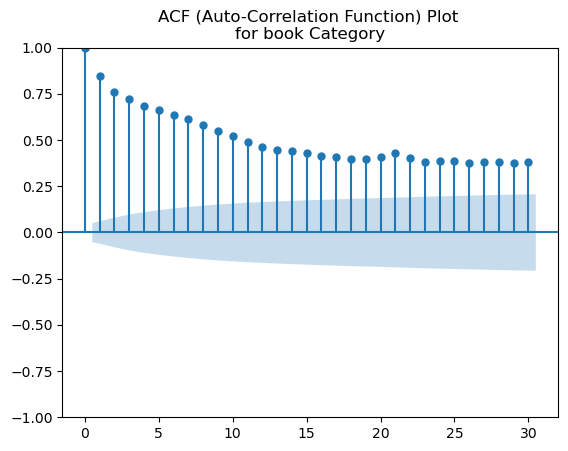

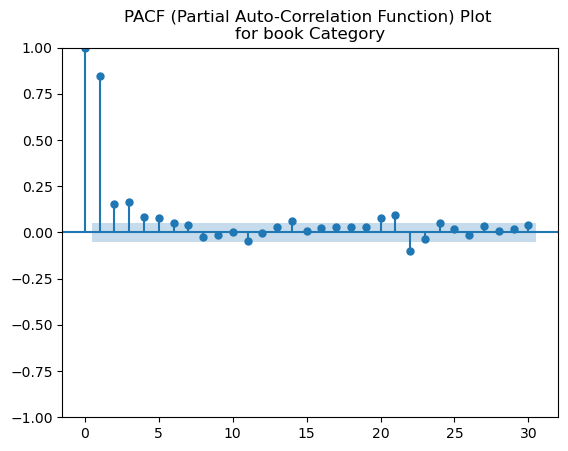

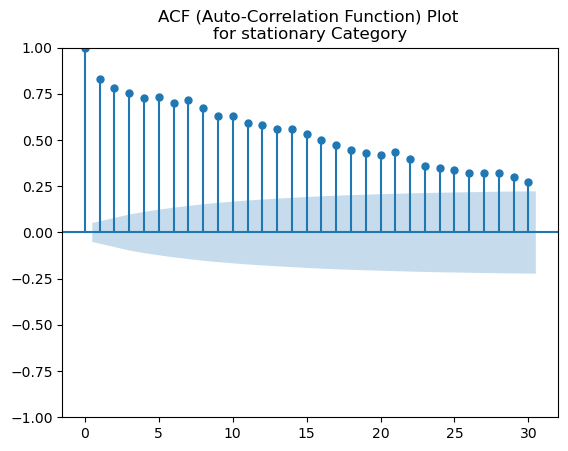

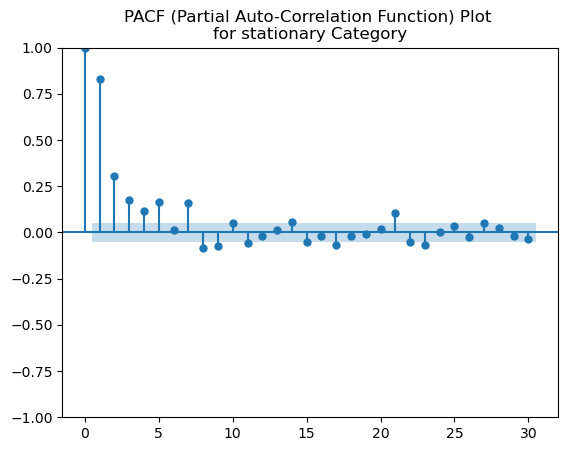

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create ACF and PACF plots for each category
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]['Net Item Sales']
    plot_acf(category_data, lags=30)  # Adjust lags as needed
    plt.title(f'ACF (Auto-Correlation Function) Plot \nfor {category} Category')
    plot_pacf(category_data, lags=30)  # Adjust lags as needed
    plt.title(f'PACF (Partial Auto-Correlation Function) Plot \nfor {category} Category')
    

3) Use Visualization techniques to describe sales trends for these 2 categories over the 4-year period. Clearly indicate the insights derived from each chart or graph. 

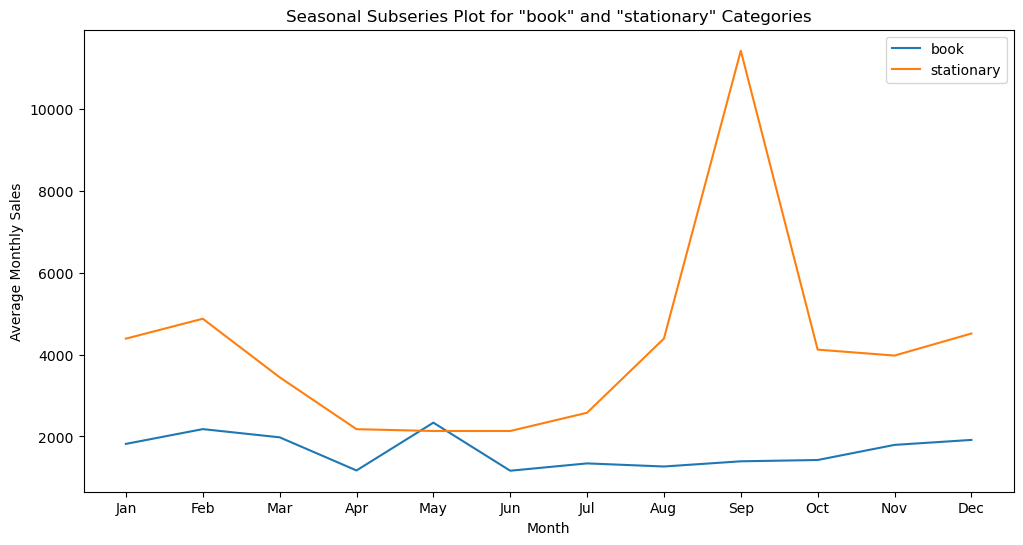

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seasonal Subseries Plot
plt.figure(figsize=(12, 6))
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]['Net Item Sales']
    seasonal_subseries = category_data.groupby(category_data.index.month).mean()
    plt.plot(seasonal_subseries, label=category)
plt.title('Seasonal Subseries Plot for "book" and "stationary" Categories')
plt.xlabel('Month')
plt.ylabel('Average Monthly Sales')
plt.xticks(range(1, 13), calendar.month_abbr[1:])
plt.legend()
plt.show()

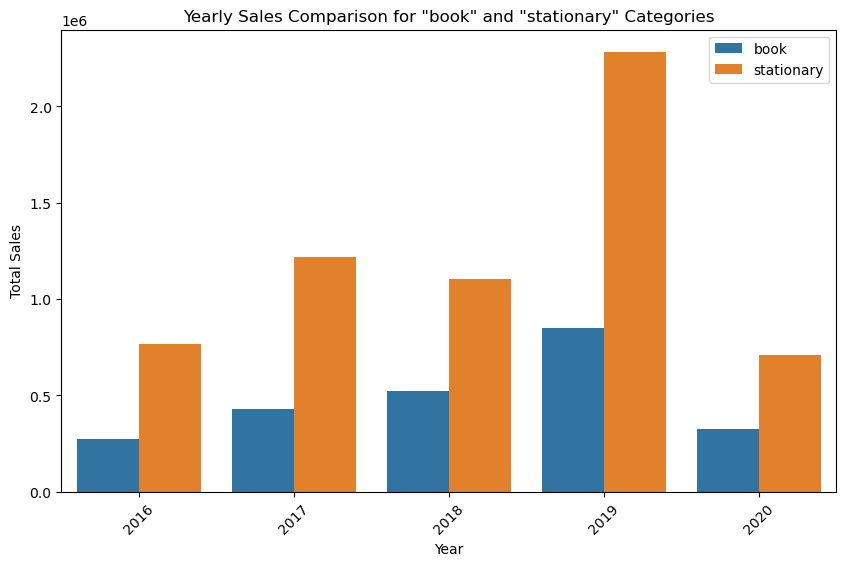

In [11]:
# Bar Chart - Yearly Sales Comparison
yearly_sales = df.groupby(['Category', df.index.year])['Net Item Sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=yearly_sales, x='Gregorian Date', y='Net Item Sales', hue='Category')
plt.title('Yearly Sales Comparison for "book" and "stationary" Categories')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

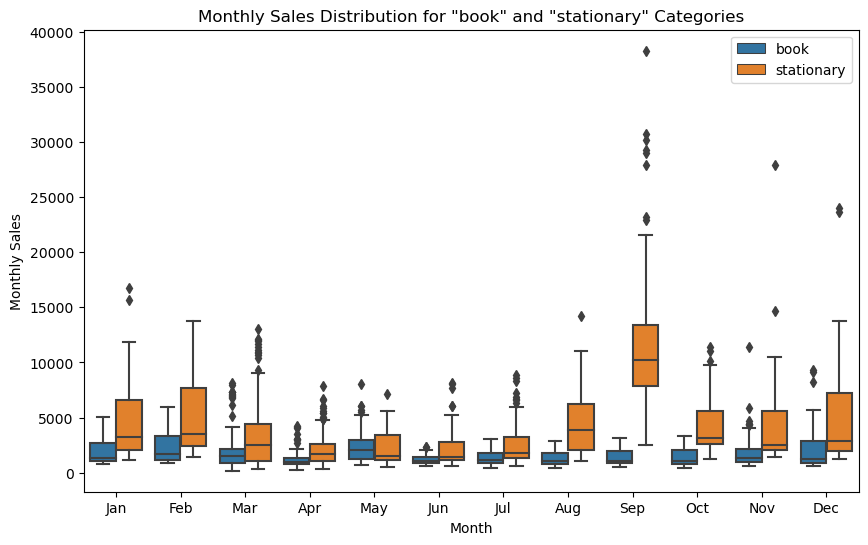

In [12]:
# Box Plot - Monthly Sales Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x=df.index.month, y='Net Item Sales', hue='Category')
plt.title('Monthly Sales Distribution for "book" and "stationary" Categories')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.xticks(range(12), calendar.month_abbr[1:])
plt.legend()
plt.show()

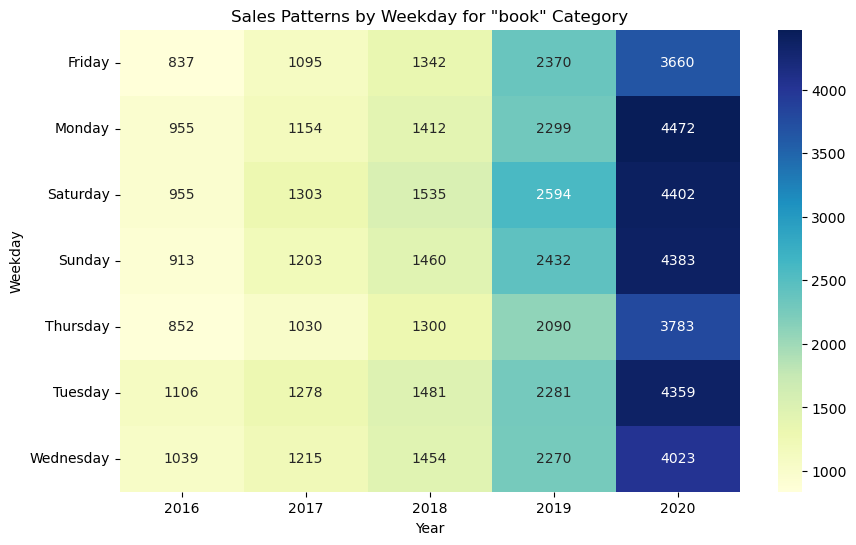

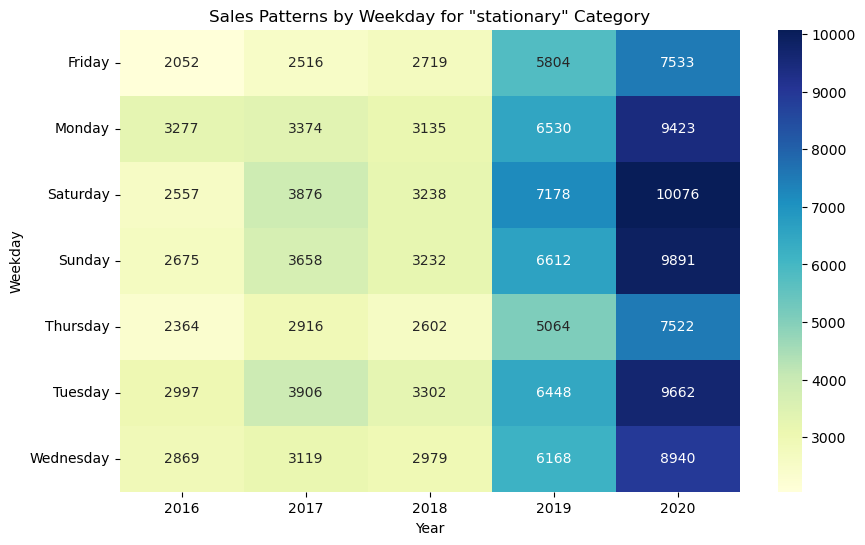

In [13]:
import calendar

# Extract weekday information from the index
df['Weekday'] = df.index.weekday

# Map weekday numbers to weekday names
weekday_names = [calendar.day_name[i] for i in range(7)]
df['Weekday'] = df['Weekday'].map(lambda x: weekday_names[x])

# Separate the data for the "book" and "stationary" categories
book_data = df[df['Category'] == 'book']
stationary_data = df[df['Category'] == 'stationary']

# Pivot the data for the heatmap - Sales Patterns by Weekday for "book" Category
book_weekday_sales = book_data.pivot_table(index='Weekday', columns=book_data.index.year, values='Net Item Sales', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(book_weekday_sales, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Sales Patterns by Weekday for "book" Category')
plt.xlabel('Year')
plt.ylabel('Weekday')
plt.show()

# Pivot the data for the heatmap - Sales Patterns by Weekday for "stationary" Category
stationary_weekday_sales = stationary_data.pivot_table(index='Weekday', columns=stationary_data.index.year, values='Net Item Sales', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(stationary_weekday_sales, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Sales Patterns by Weekday for "stationary" Category')
plt.xlabel('Year')
plt.ylabel('Weekday')
plt.show()


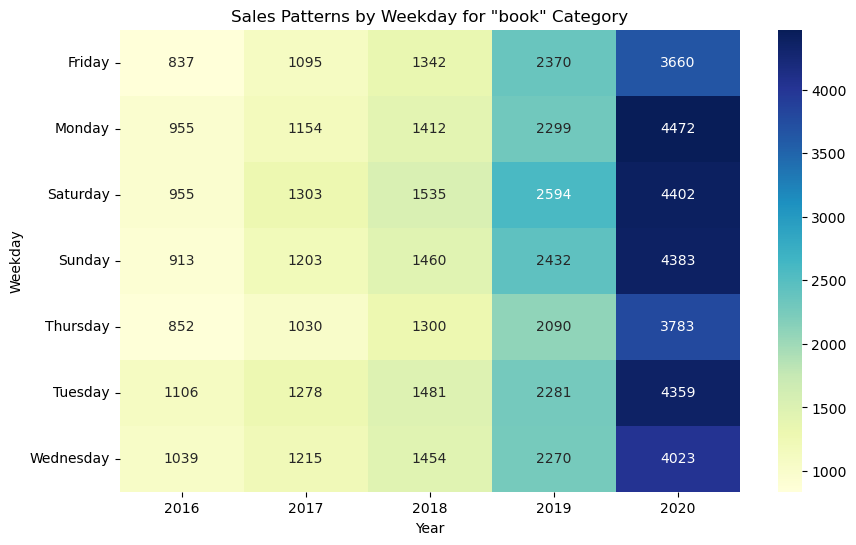

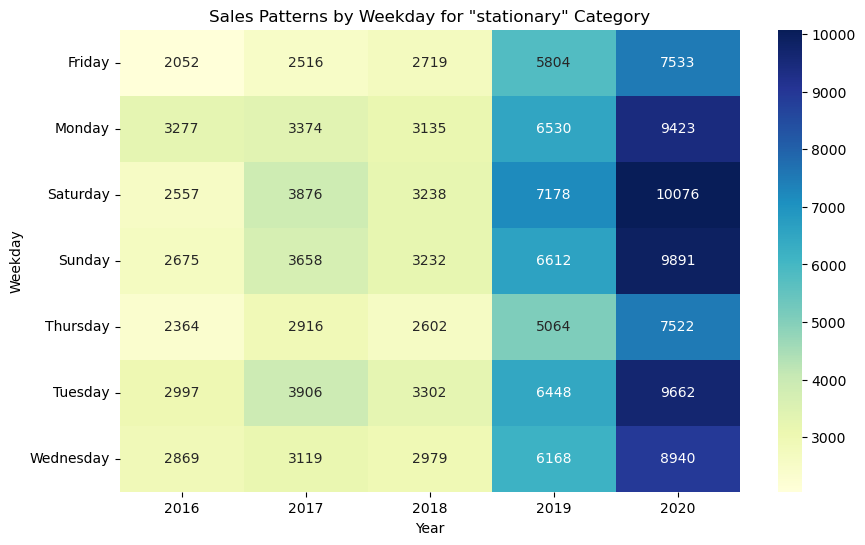

In [14]:
import calendar

# Extract weekday information from the index
df['Weekday'] = df.index.weekday

# Map weekday numbers to weekday names
weekday_names = [calendar.day_name[i] for i in range(7)]
df['Weekday'] = df['Weekday'].map(lambda x: weekday_names[x])

# Separate the data for the "book" and "stationary" categories
book_data = df[df['Category'] == 'book']
stationary_data = df[df['Category'] == 'stationary']

# Pivot the data for the heatmap - Sales Patterns by Weekday for "book" Category
book_weekday_sales = book_data.pivot_table(index='Weekday', columns=book_data.index.year, values='Net Item Sales', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(book_weekday_sales, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Sales Patterns by Weekday for "book" Category')
plt.xlabel('Year')
plt.ylabel('Weekday')
plt.show()

# Pivot the data for the heatmap - Sales Patterns by Weekday for "stationary" Category
stationary_weekday_sales = stationary_data.pivot_table(index='Weekday', columns=stationary_data.index.year, values='Net Item Sales', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(stationary_weekday_sales, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Sales Patterns by Weekday for "stationary" Category')
plt.xlabel('Year')
plt.ylabel('Weekday')
plt.show()


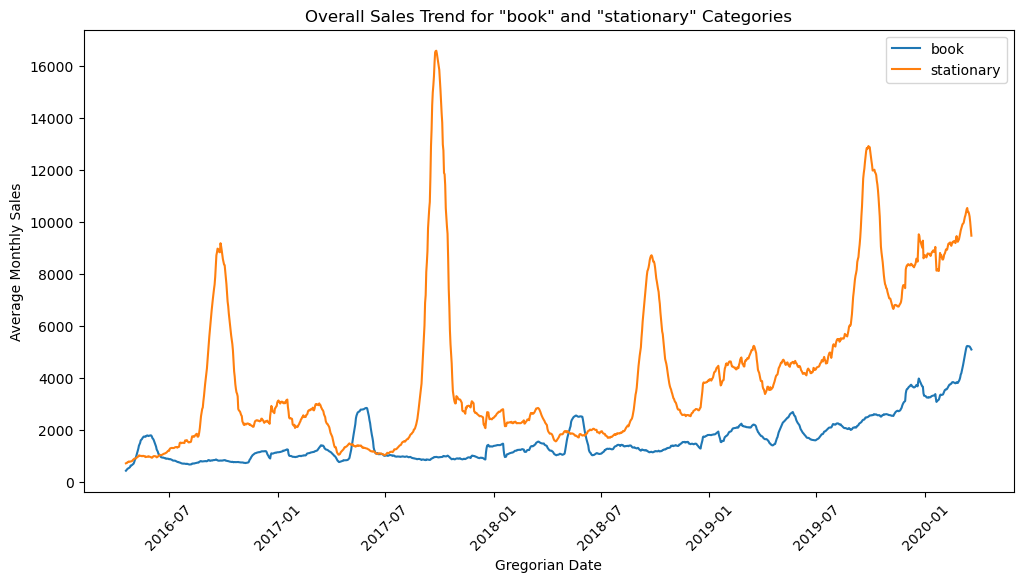

In [15]:
# Line Chart with Trendline - Overall Trend
plt.figure(figsize=(12, 6))
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]['Net Item Sales']
    trend = category_data.rolling(window=30).mean()
    plt.plot(category_data.index, trend, label=category)
plt.title('Overall Sales Trend for "book" and "stationary" Categories')
plt.xlabel('Gregorian Date')
plt.ylabel('Average Monthly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# # Create a line chart for monthly total sales for each category
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=grouped_data, x='Gregorian Month Number', y='Net Item Sales', hue='Category')
# plt.xlabel('Gregorian Month Number')
# plt.ylabel('Total Sales')
# plt.title('Monthly Total Sales Trends for Each Category')
# plt.legend()
# plt.xticks(range(1, 13), calendar.month_abbr[1:])  # Use abbreviated month names
# #plt.tight_layout()
# plt.show()

4) Based on the provided historical data, utilize forecasting techniques to predict monthly sales for "stationary" in the year 1399. In your response, clearly state your assumptions, outline the specific factors you considered, and elaborate on the forecasting methods or models you employed.

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


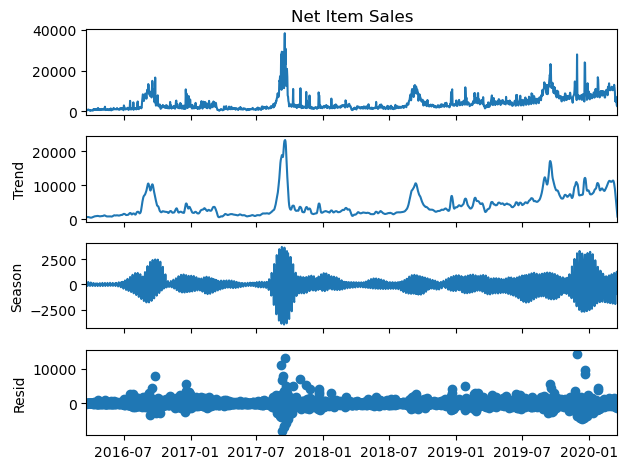

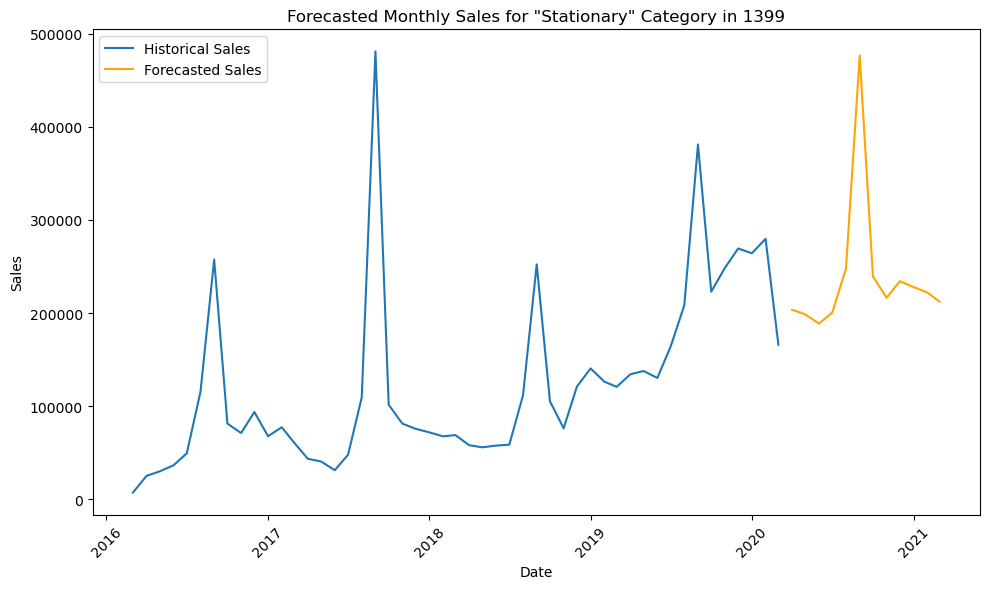

,Forecasted Sales
Date,
2020-04-01,203597.349867
2020-05-01,198602.389719
2020-06-01,188720.444553
2020-07-01,200558.210903
2020-08-01,248005.362335
2020-09-01,476509.566763
2020-10-01,239251.919053
2020-11-01,216432.714021
2020-12-01,234266.819513


In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

# Extract sales data for the "stationary" category
stationary_data = df[df['Category'] == 'stationary']['Net Item Sales']

# Resample the historical data to a monthly basis
stationary_data_monthly = stationary_data.resample('MS').sum()

# Perform STL decomposition for each category
category_data = stationary_data
stl = STL(category_data, seasonal=13)  # Adjust seasonal parameter as needed
result = stl.fit()
result.plot()

# Forecasting using Exponential Smoothing
model = ExponentialSmoothing(stationary_data_monthly, seasonal='additive', seasonal_periods=12)
model_fit = model.fit()

# Forecast sales for the year 1399
forecasted_sales = model_fit.forecast(steps=12)  # Assuming 12 months in the year

# Create a date range for the forecasted months in 1399
forecast_dates = pd.date_range(start=JalaliDate(1399, 1, 1).to_gregorian(), periods=12, freq='MS')

# Create a DataFrame to store the forecasted sales
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Sales': forecasted_sales})
forecast_df.set_index('Date', inplace=True)

# Plot the historical sales and forecasted sales
plt.figure(figsize=(10, 6))
plt.plot(stationary_data_monthly.index, stationary_data_monthly.values, label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecasted Sales'], label='Forecasted Sales', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecasted Monthly Sales for "Stationary" Category in 1399')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the forecasted sales for the year 1399
display(pd.DataFrame(forecast_df))


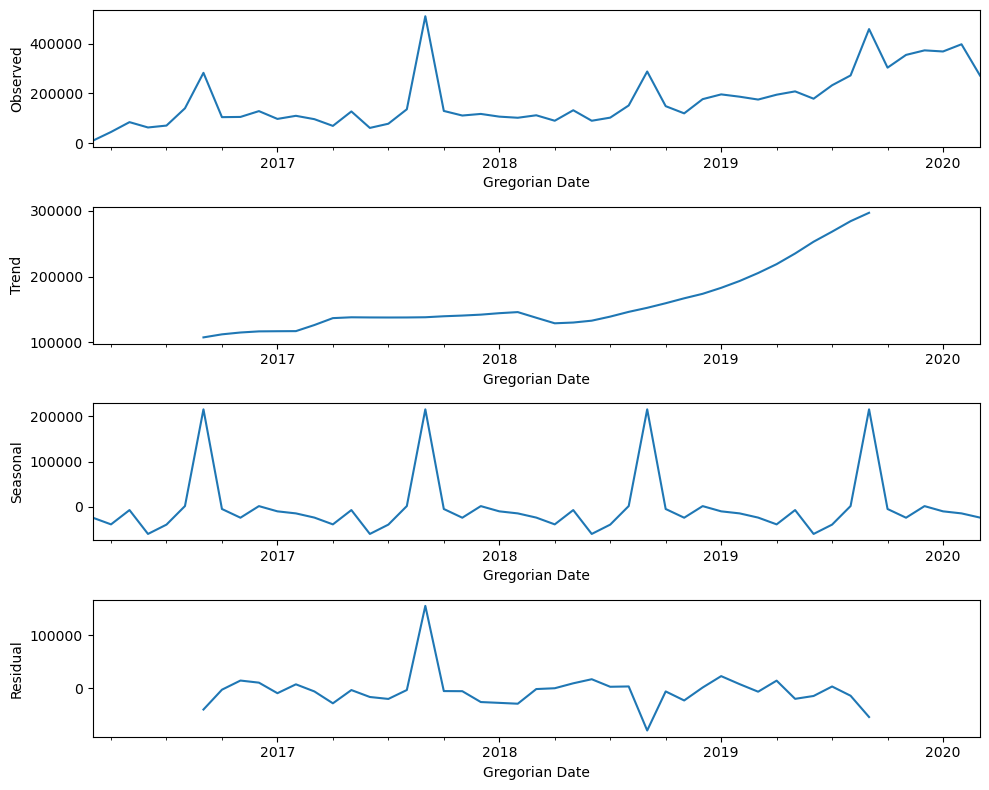

In [17]:
# Resample to monthly frequency and sum the sales
df_monthly = df['Net Item Sales'].resample('M').sum()

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df_monthly, model='additive')

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

In [18]:

# Fit an ARIMA model to the data
model = sm.tsa.ARIMA(df['Net Item Sales'], order=(1, 1, 1))
results = model.fit()

# Print model summary
print(results.summary())

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packa

                               SARIMAX Results                                
Dep. Variable:         Net Item Sales   No. Observations:                 2920
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -25484.370
Date:                Mon, 28 Aug 2023   AIC                          50974.741
Time:                        15:16:30   BIC                          50992.678
Sample:                             0   HQIC                         50981.202
                               - 2920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2063      0.009     23.857      0.000       0.189       0.223
ma.L1         -0.7057      0.007    -95.624      0.000      -0.720      -0.691
sigma2      2.317e+06   1.33e+04    174.346      0.0

In [19]:
grouped_data = df.groupby(['Category', 'Gregorian Year', 'Gregorian Month Number'])['Net Item Sales'].sum().reset_index()

stationary_data = grouped_data[grouped_data['Category'] == 'stationary']

In [20]:
# Group data by month and calculate total monthly sales
monthly_sales = stationary_data.groupby(['Gregorian Year', 'Gregorian Month Number'])['Net Item Sales'].sum()

# Reset index to make it easier for forecasting
monthly_sales = monthly_sales.reset_index()

# Convert the 'Gregorian Month Number' column to integer
monthly_sales['Gregorian Month Number'] = monthly_sales['Gregorian Month Number'].astype(int)

# Create a time series from the data
ts = monthly_sales.set_index(pd.to_datetime(monthly_sales['Gregorian Year'].astype(str) + '-' + monthly_sales['Gregorian Month Number'].astype(str))).drop(['Gregorian Year', 'Gregorian Month Number'], axis=1)

In [21]:
# Split the data into training and testing sets
train_size = int(len(ts) * 37/49)
train_data = ts.iloc[:train_size]
test_data = ts.iloc[train_size:]

In [22]:
# Convert Persian start and end dates to Gregorian
forecast_start = JalaliDate(1399, 1, 1).to_gregorian()
forecast_end = JalaliDate(1399, 12, 29).to_gregorian()

# Fit the SARIMA model
order = (1, 1, 1)  # You can adjust these parameters based on model evaluation
seasonal_order = (1, 1, 1, 12)  # Assuming yearly seasonality
model = sm.tsa.SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                     Net Item Sales   No. Observations:                   37
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -123.077
Date:                            Mon, 28 Aug 2023   AIC                            256.155
Time:                                    15:16:30   BIC                            257.668
Sample:                                03-01-2016   HQIC                           254.495
                                     - 03-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7094     13.322      0.053      0.958     -25.402      26.821
ma.L1         -0.9503      4.011   

In [23]:
# Forecast sales for the year 1399
forecast = results.get_forecast(steps=12)  # Forecasting for 12 months

forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='MS')
forecast_values = forecast.predicted_mean.values


pd.DataFrame(forecast.predicted_mean)

,predicted_mean
2019-04-01,110376.805807
2019-05-01,106755.395459
2019-06-01,102030.308218
2019-07-01,111094.326726
2019-08-01,161782.379765
2019-09-01,388873.879259
2019-10-01,148926.155669
2019-11-01,131743.682941
2019-12-01,141650.306641
2020-01-01,138077.169862


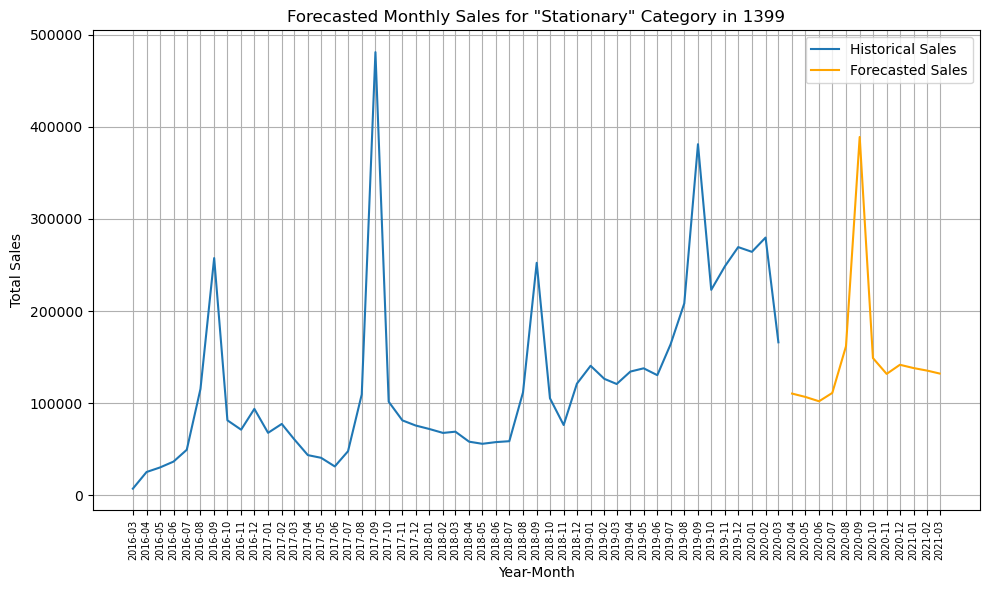

In [24]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(ts.index, ts.values, label='Historical Sales')
plt.plot(forecast_index, forecast_values, label='Forecasted Sales', color='orange')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.title('Forecasted Monthly Sales for "Stationary" Category in 1399')
plt.legend()

xtixks=(ts.index).append(forecast_index)
# Set xticks for historical sales
plt.xticks(xtixks, [date.strftime('%Y-%m') for date in xtixks], rotation=90, size=7)

# Manually adjust the spacing to make xticks for historical sales visible
plt.subplots_adjust(bottom=0.15)

plt.tight_layout()
plt.grid(True)
plt.show()


5) Continuing from question 4, considering the "stationary" category, break down your predicted sales for the first 3 months of the year into daily sales figures for each day of the month. Explain factors or methods you consider in making this breakdown.

            Daily Sales
2020-03-20  6567.656447
2020-03-21  6567.656447
2020-03-22  6567.656447
2020-03-23  6567.656447
2020-03-24  6567.656447
...                 ...
2020-06-13  6290.681485
2020-06-14  6290.681485
2020-06-15  6290.681485
2020-06-16  6290.681485
2020-06-17  6290.681485

[90 rows x 1 columns]


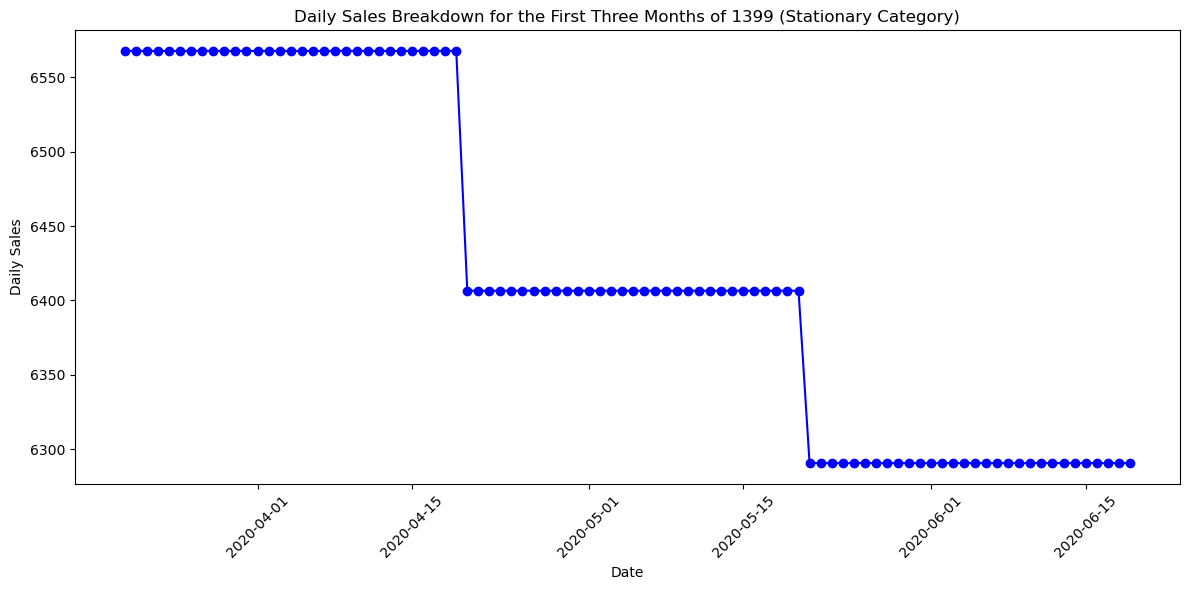

In [25]:
# Assuming you have 'forecast_df' DataFrame from the previous step
# Calculate the average daily sales during historical first three months
historical_avg_daily_sales = stationary_data_monthly[:3].mean()

# Calculate the total predicted sales for each month
predicted_monthly_sales = forecast_df['Forecasted Sales']

# Define the number of days in each month for the first three months
days_in_month = [31, 31, 30]  # Replace with actual days for the corresponding months

# Initialize a list to store daily sales breakdown
daily_sales_breakdown = []

# Iterate through each month
for i, monthly_sales in enumerate(predicted_monthly_sales):
    if i < len(days_in_month):  # Ensure we have enough months in 'days_in_month'
        days = days_in_month[i]
        avg_daily_sales = monthly_sales / days
        daily_sales = [avg_daily_sales] * days
        daily_sales_breakdown.extend(daily_sales)

# Create a DataFrame to store the daily sales breakdown
daily_sales_df = pd.DataFrame({'Daily Sales': daily_sales_breakdown},
                              index=pd.date_range(start=JalaliDate(1399, 1, 1).to_gregorian(), periods=len(daily_sales_breakdown), freq='D'))

# Display the daily sales breakdown for the first three months
print(daily_sales_df.head(90))  # Display first 3 months (90 days)

# Plot the daily sales breakdown for the first three months
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_df.index, daily_sales_df['Daily Sales'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('Daily Sales Breakdown for the First Three Months of 1399 (Stationary Category)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,Daily Sales
2020-03-20,4397.789474
2020-03-21,4524.985646
2020-03-22,4127.937799
2020-03-23,3528.263158
2020-03-24,3562.793269
...,...
2020-06-13,3562.793269
2020-06-14,4609.701923
2020-06-15,4430.355769
2020-06-16,4397.789474


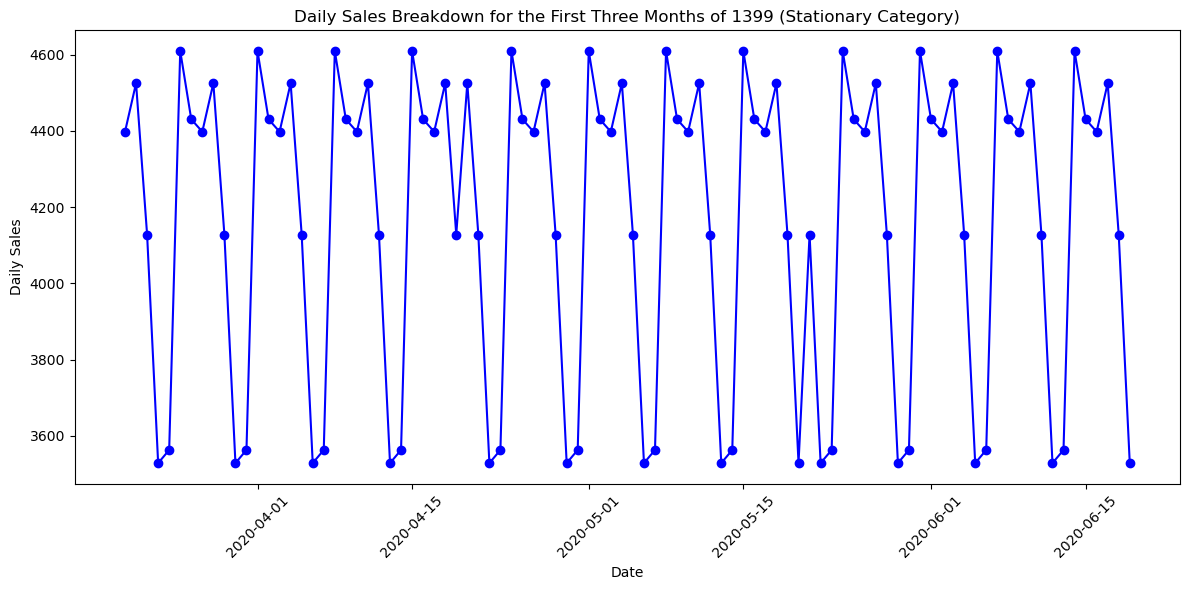

In [26]:
stationary_data = df[df['Category'] == 'stationary']

# Calculate the average daily sales for each weekday based on historical data
weekday_avg_sales = stationary_data.groupby(stationary_data.index.dayofweek)['Net Item Sales'].mean()

# Calculate the total predicted sales for each month
predicted_monthly_sales = forecast_df['Forecasted Sales']

# Define the number of days in each month for the first three months
days_in_month = [31, 31, 30]  # Replace with actual days for the corresponding months

# Initialize a list to store daily sales breakdown
daily_sales_breakdown = []

# Iterate through each month
for i, monthly_sales in enumerate(predicted_monthly_sales):
    if i < len(days_in_month):  # Ensure we have enough months in 'days_in_month'
        days = days_in_month[i]
        avg_daily_sales = monthly_sales / days

        # Distribute average daily sales based on weekday pattern
        daily_sales = []
        for day in range(days):
            weekday = (i + day) % 7  # Calculate the weekday for the day
            avg_sales_weekday = weekday_avg_sales[weekday]
            daily_sales.append(avg_sales_weekday)

        daily_sales_breakdown.extend(daily_sales)

# Create a DataFrame to store the daily sales breakdown
daily_sales_df = pd.DataFrame({'Daily Sales': daily_sales_breakdown},
                              index=pd.date_range(start=JalaliDate(1399, 1, 1).to_gregorian(), periods=len(daily_sales_breakdown), freq='D'))

# Display the daily sales breakdown for the first three months
display(daily_sales_df.head(90))  # Display first 3 months (90 days)

# Plot the daily sales breakdown for the first three months
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_df.index, daily_sales_df['Daily Sales'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('Daily Sales Breakdown for the First Three Months of 1399 (Stationary Category)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Export the first 90 rows of daily_sales_df to Excel
excel_filename = "daily_sales_breakdown.xlsx"
daily_sales_df.head(90).to_excel(excel_filename)

print(f"Daily sales breakdown exported to {excel_filename}")

Daily sales breakdown exported to daily_sales_breakdown.xlsx
